# Predict Stabilizing Variants via Deep Mutational Scan

While ESM2 has similar performance to ESM-1v, the latter is still a great option for performing an _in silico_ deep mutational scan. ESM-1v is a collection of five models, each trained on a different set of sequences from UniRef, where each set differs in its sequence identity threshold. Ensembling these five models' scores can produce better results than a single model for such broad topics like identifying stabilizing mutations.

Since these models were _only_ trained on functional molecules, they are capable of assessing whether a new molecule might also be functional, or whether it has a disastrous mutation. Imagine only learning and speaking English your whole life - could you identify whether a new English word is English? Whether a Korean word is English? Whether a French word is English? You might not be able to identify a Korean word as specifically Korean, but it looks and sounds foreign enough to you that you could identify it as non-English. The idea is similar. Instead, here, we have a neural net trained on the language of functional molecules, and we can ask it whether new ones are functional, as well.

In [41]:
import copy
import json
import os, sys
import requests
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns

from matplotlib import pyplot as plt

# Add Python module with utility functions for interacting with BioLM API
repo_root = os.path.join(os.getcwd(), '..', '..')
src_dir = os.path.join(repo_root, 'src')
if src_dir not in sys.path:
    sys.path.append(src_dir)
    
import biolm_util

We do this by masking each position and requesting the scores for each residue at that position. For a sequence of even a couple hundred residues, this is thousands of predictions from each of the 5 GPU-based models. [BioLM has APIs](https://api.biolm.ai/#54d3367a-b5d1-4f18-aa44-23ae3914a446) to get these results at scale much faster than it would take to scale out these models on multiple GPUs alone.

In [11]:
tokens = biolm_util.get_api_token()  # They should be set as env vars now, so not needed

In [12]:
# Let's use the sequence from the paper
# https://www.biorxiv.org/content/10.1101/2021.07.09.450648v2.full.pdf
wt = "ASKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTFSYGVQCFSRYPDHMKRHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK"

print("Sequence length: {}".format(len(wt)))

Sequence length: 238


We can copy working Python code for making a request to BioLM.ai's ESM-1v API:

In [13]:
def esm1v_pred(seq, model_num=1):
    """Get un-masking predictions from any of the 5 ESM-1v models via REST API.
    
    From API docs: https://api.biolm.ai/#54d3367a-b5d1-4f18-aa44-23ae3914a446
    """
    url = f"https://biolm.ai/api/v1/models/esm1v_t33_650M_UR90S_{model_num}/predict/"
    
    assert '<mask>' in seq
    assert 5 >= model_num >= 1

    payload = json.dumps({
      "instances": [
        {
          "data": {
            "text": seq
          }
        }
      ]
    })
    
    # Minor adaptation to docs in order to read token from env vars
    access = os.environ.get('BIOLM_ACCESS')
    refresh = os.environ.get('BIOLM_REFRESH')
    headers = {
      'Cookie': 'access={};refresh={}'.format(access, refresh),
      'Content-Type': 'application/json'
    }

    response = requests.request("POST", url, headers=headers, data=payload)
    
    return response.json()

Now test our function on the first residue and first model.

In [14]:
api_tok = biolm_util.get_api_token()
os.environ['BIOLM_ACCESS'] = api_tok['access']
os.environ['BIOLM_REFRESH'] = api_tok['refresh']

esm1v_pred('<mask>' + wt[1:])

{'predictions': [[{'score': 0.9092302322387695,
    'token': 20,
    'token_str': 'M',
    'sequence': 'M S K G E E L F T G V V P I L V E L D G D V N G H K F S V S G E G E G D A T Y G K L T L K F I C T T G K L P V P W P T L V T T F S Y G V Q C F S R Y P D H M K R H D F F K S A M P E G Y V Q E R T I F F K D D G N Y K T R A E V K F E G D T L V N R I E L K G I D F K E D G N I L G H K L E Y N Y N S H N V Y I M A D K Q K N G I K V N F K I R H N I E D G S V Q L A D H Y Q Q N T P I G D G P V L L P D N H Y L S T Q S A L S K D P N E K R D H M V L L E F V T A A G I T H G M D E L Y K'},
   {'score': 0.008935132995247841,
    'token': 4,
    'token_str': 'L',
    'sequence': 'L S K G E E L F T G V V P I L V E L D G D V N G H K F S V S G E G E G D A T Y G K L T L K F I C T T G K L P V P W P T L V T T F S Y G V Q C F S R Y P D H M K R H D F F K S A M P E G Y V Q E R T I F F K D D G N Y K T R A E V K F E G D T L V N R I E L K G I D F K E D G N I L G H K L E Y N Y N S H N V Y I M A D K Q K N G I K V N

And we can also quickly get predictions from the other models:

In [15]:
res = esm1v_pred('<mask>' + wt[1:], model_num=2)

res

{'predictions': [[{'score': 0.9457132816314697,
    'token': 20,
    'token_str': 'M',
    'sequence': 'M S K G E E L F T G V V P I L V E L D G D V N G H K F S V S G E G E G D A T Y G K L T L K F I C T T G K L P V P W P T L V T T F S Y G V Q C F S R Y P D H M K R H D F F K S A M P E G Y V Q E R T I F F K D D G N Y K T R A E V K F E G D T L V N R I E L K G I D F K E D G N I L G H K L E Y N Y N S H N V Y I M A D K Q K N G I K V N F K I R H N I E D G S V Q L A D H Y Q Q N T P I G D G P V L L P D N H Y L S T Q S A L S K D P N E K R D H M V L L E F V T A A G I T H G M D E L Y K'},
   {'score': 0.004730956628918648,
    'token': 4,
    'token_str': 'L',
    'sequence': 'L S K G E E L F T G V V P I L V E L D G D V N G H K F S V S G E G E G D A T Y G K L T L K F I C T T G K L P V P W P T L V T T F S Y G V Q C F S R Y P D H M K R H D F F K S A M P E G Y V Q E R T I F F K D D G N Y K T R A E V K F E G D T L V N R I E L K G I D F K E D G N I L G H K L E Y N Y N S H N V Y I M A D K Q K N G I K V N

You can observe the probabilities for each token (amino acid residue) differing between the two models.

Loading the data into a DF is simple.

In [16]:
pd.DataFrame.from_dict(res['predictions'][0], orient='columns')

,score,token,token_str,sequence
0,0.945713,20,M,M S K G E E L F T G V V P I L V E L D G D V N ...
1,0.004731,4,L,L S K G E E L F T G V V P I L V E L D G D V N ...
2,0.004624,6,G,G S K G E E L F T G V V P I L V E L D G D V N ...
3,0.004320,8,S,S S K G E E L F T G V V P I L V E L D G D V N ...
4,0.003869,15,K,K S K G E E L F T G V V P I L V E L D G D V N ...
5,0.003802,7,V,V S K G E E L F T G V V P I L V E L D G D V N ...
6,0.003527,12,I,I S K G E E L F T G V V P I L V E L D G D V N ...
7,0.003489,5,A,A S K G E E L F T G V V P I L V E L D G D V N ...
8,0.003188,9,E,E S K G E E L F T G V V P I L V E L D G D V N ...
9,0.003166,11,T,T S K G E E L F T G V V P I L V E L D G D V N ...


Let's scan the whole sequence now, using all five models. I could write some code to parallelize the HTTP requests or mask multiple positions in one request, but this should be fairly fast sequentially. Let's simply loop through each model and position.

In [18]:
%%time

results = []

# For each ESM-1v model...
for mdl in range(1, 6):
    # And now for each character position in the protein sequence...
    for idx in range(len(wt)):
        if idx % 20 == 0:
            print("On position {}/{} for model {}".format(idx, len(wt), mdl))
        # Mask that position
        seq_masked = list(copy.copy(wt))
        seq_masked[idx] = '<mask>'
        seq_masked = ''.join(seq_masked)
    
        # Request the probabilities of each AA at that mask
        r = esm1v_pred(seq_masked, model_num=mdl)
        r_df = pd.DataFrame.from_dict(r['predictions'][0], orient='columns')
        r_df['model_num'] = mdl
        r_df['mask_pos'] = idx
        results.append(r_df)

On position 0/238 for model 1
On position 20/238 for model 1
On position 40/238 for model 1
On position 60/238 for model 1
On position 80/238 for model 1
On position 100/238 for model 1
On position 120/238 for model 1
On position 140/238 for model 1
On position 160/238 for model 1
On position 180/238 for model 1
On position 200/238 for model 1
On position 220/238 for model 1
On position 0/238 for model 2
On position 20/238 for model 2
On position 40/238 for model 2
On position 60/238 for model 2
On position 80/238 for model 2
On position 100/238 for model 2
On position 120/238 for model 2
On position 140/238 for model 2
On position 160/238 for model 2
On position 180/238 for model 2
On position 200/238 for model 2
On position 220/238 for model 2
On position 0/238 for model 3
On position 20/238 for model 3
On position 40/238 for model 3
On position 60/238 for model 3
On position 80/238 for model 3
On position 100/238 for model 3
On position 120/238 for model 3
On position 140/238 for mo

In [19]:
results_df = pd.concat(results, axis=0)

results_df.shape

(23800, 6)

In [20]:
results_df.sample(5)

,score,token,token_str,sequence,model_num,mask_pos
10,0.037818,7,V,A S K G E E L F T G V V P I L V E L D G D V N ...,5,65
9,0.035636,6,G,A S K G E E L F T G V V P I L V E L D G D V N ...,2,104
8,0.040273,13,D,A S K G E E L F T G V V P I L V E L D G D V N ...,2,104
10,0.050459,10,R,A S K G E E L F T G V V P I L V E L D G D V N ...,3,164
16,0.015867,12,I,A S K G E E L F T G V V P I L V E L D G D V N ...,5,120


Let's quickly fill in the WT character for each row so we can plot the results.

In [23]:
results_df['wt_token_str'] = results_df.mask_pos.apply(lambda x: wt[x])

results_df.sample(3)

,score,token,token_str,sequence,model_num,mask_pos,wt_token_str
8,0.051471,5,A,A S K G E E L F T G V V P I L V E L D G D V N ...,1,128,D
1,0.097080,7,V,A S K G E E L F T G V V P I L V E L D G D V N ...,1,190,G
8,0.052985,4,L,A S K G E E L F T G V V P I L V E L D G D V N ...,5,98,F


Lastly, quickly make a DF displaying a heatmap of the most probable stabilizing variants from the _in silico_ deep mutational scan.

In [37]:
heatmap_df = []  # Each row represents the full sequence, with a single token_str at each position

for residue in results_df.token_str.drop_duplicates().to_list():
    tmp_row = []
    for pos in range(len(wt)):
        token_position_score = results_df.query('token_str == @residue & mask_pos == @pos').score.iloc[0]
        tmp_row.append(token_position_score)
    heatmap_df.append(tmp_row)

In [38]:
heatmap_df = pd.DataFrame(heatmap_df)

heatmap_df.shape

(20, 238)

In [39]:
heatmap_df.head(1).iloc[0][0]

0.9092302322387695

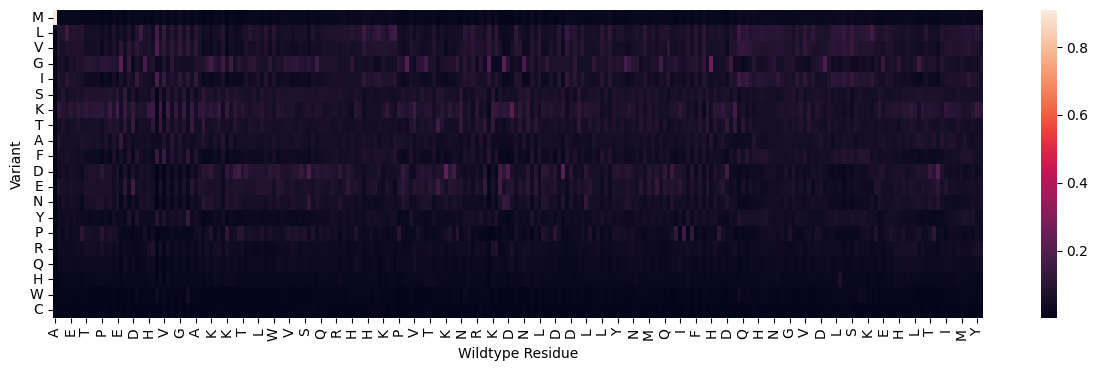

In [89]:
fig = plt.figure(figsize=[15, 4])

ax = sns.heatmap(heatmap_df)
_ = ax.set_xticklabels(list(wt)[::int(len(wt)/50)])
_ = ax.set_yticklabels(results_df.token_str.drop_duplicates())
_ = ax.set(xlabel='Wildtype Residue', ylabel='Variant')

This is a quick depiciton of the results. What you want to look for in the DF is mutations where the score is greater than the score of the wild-type residue at the same location. This can be done with some quick slicing of `results_df`, which we'll leave up to you to explore.